In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
gdal.UseExceptions()

ds = gdal.Open('../USGS_one_meter_x28y430_MD_VA_Sandy_NCR_2014.tif')
band = ds.GetRasterBand(1)
elevation1 = band.ReadAsArray()

In [3]:
gdal.UseExceptions()

ds = gdal.Open('../USGS_Colorado.tif')
band = ds.GetRasterBand(1)
elevation_C = band.ReadAsArray()

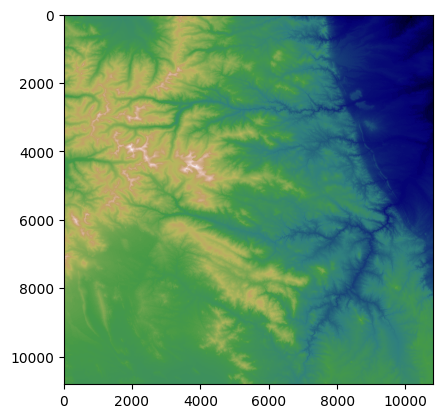

In [4]:
plt.imshow(elevation_C, cmap='gist_earth')
plt.show()

In [96]:
# eval1_proc = np.copy(elevation1[:500,2370:2870])
eval1_proc = np.copy(elevation1[400:600,2300:2500])
nan_exist = 0
min_val = 10000
max_val = -10000
for i, line in enumerate(eval1_proc):
    for j, el in enumerate(line):
        if el < -1000:
            eval1_proc[i][j] = np.nan
#             eval1_proc[i][j] = 50
            nan_exist = 1
        else:
            if el > max_val:
                max_val = el
            if el < min_val:
                min_val = el
if nan_exist:
    print('missed value')
            
print(min_val, max_val)
# print(eval1_proc.shape, eval1_proc)

missed value
47.41281 50.78265


## Missed data generator

In [5]:
import queue
from random import randint
nan_const = -9999



def BFS(arr, q, used):
    while not q.empty():
        i, j = q.get()
        sum_around = 0
        cnt_around = 0
        #one meter distance
        for k in range(-1, 2):
            for p in range(-1, 2):
                if 0 <= i + k < arr.shape[0] and 0 <= j + p < arr.shape[1] \
                        and arr[i + k][j + p] > nan_const:
                    cnt_around += 4
                    sum_around += 4 * arr[i + k][j + p]

        #<= two meters distance (count one miter values second time)
        for k in range(-2, 3):
            if 0 <= i + k < arr.shape[0]:
                for p in range(-2, 3):
                    if 0 <= j + p < arr.shape[1] \
                            and arr[i + k][j + p] > nan_const:
                        cnt_around += 1
                        sum_around += arr[i + k][j + p]
        
        #generate arr[i][j] value
        random_number = randint(100, 1000)
        if random_number % 2 == 0:
            arr[i][j] = sum_around / cnt_around + random_number / 15000 #mod 100000, 20000
        else:
            arr[i][j] = sum_around / cnt_around - random_number / 15000
        
        # add new missed values to the queue
        for k in range(-1, 2):
            if 0 <= i + k < arr.shape[0]:
                for p in range(-1, 2):
                    if 0 <= j + p < arr.shape[1] and arr[i + k][j + p] <= nan_const:
                        if (i+k, j+p) not in used:
                            q.put([i + k, j + p])
                            used.add((i+k, j+p))


def gen(arr):
    q = queue.Queue()
    used = set()
    global min_val, max_val
    for i, line in enumerate(arr):
        for j, el in enumerate(line):
            if el > nan_const:
                if el > max_val:
                    max_val = el
                if el < min_val:
                    min_val = el
                for i1 in range(-1, 2):
                    for j1 in range(-1, 2):
                        if 0 <= i + i1 < arr.shape[0] and 0 <= j + j1 < arr.shape[1] \
                                and arr[i + i1][j + j1] <= nan_const:
                            q.put([i + i1, j + j1])
    BFS(arr, q, used)
                    

In [4]:
min_val = 9998
max_val = -9998

In [6]:
min_val = 9998
max_val = -9998

eval1_proc = np.copy(elevation1[400:600,2300:2500])

gen(eval1_proc)

## Visualiser:

In [7]:
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
from matplotlib import cm
from matplotlib.colors import LightSource

In [8]:

def draw_plt(arr, min_val, max_val):
    plt.figure(figsize=(10, 10), dpi=800)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(arr.shape[0])
    y = np.arange(arr.shape[1])
    X, Y = np.meshgrid(x, y)


    z = np.ravel(arr)
    Z = z.reshape(X.shape)



    ls = LightSource(270, 45)
    rgb = ls.shade(Z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb,
                           linewidth=0, antialiased=False, shade=False, vmin=min_val, vmax=max_val)

#     norm_colorbar = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

    # fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.2)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.gcf().set_size_inches(10, 10) #figure size
    
    #changing the scale of Z axes to avoid "jumps"
    ax.set_box_aspect(aspect = (arr.shape[0], arr.shape[1], max_val - min_val))
    
    if max_val - min_val < 25:
        ax.set_zticks([])
    # ax.set_zlim(40, 55)

    plt.show()

<Figure size 8000x8000 with 0 Axes>

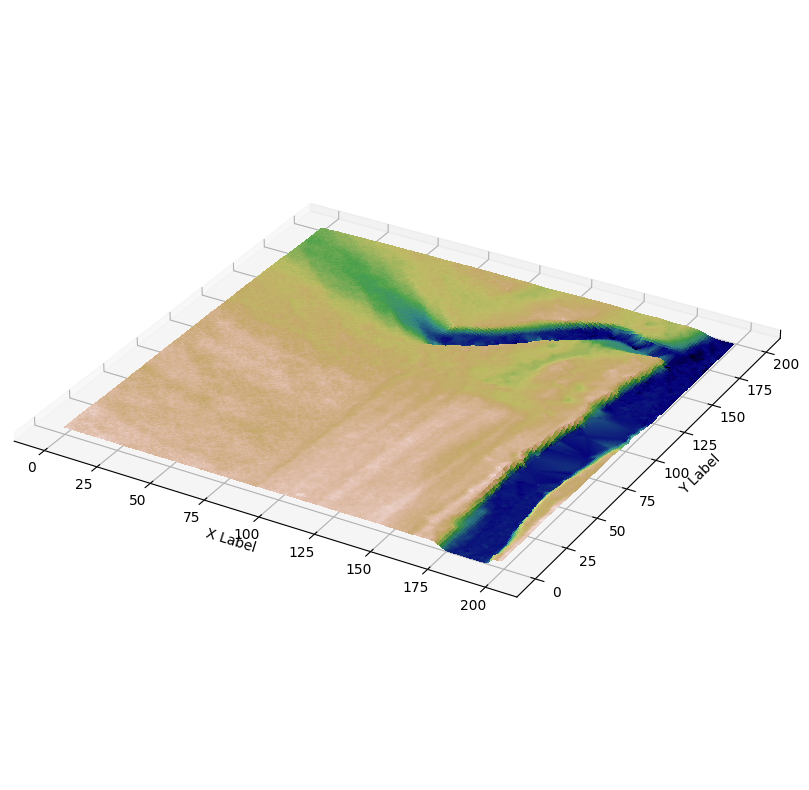

In [9]:
min_val = 9998
max_val = -9998

eval1_proc = np.copy(elevation1[400:600,2300:2500])

gen(eval1_proc)
draw_plt(eval1_proc, min_val, max_val)

<Figure size 8000x8000 with 0 Axes>

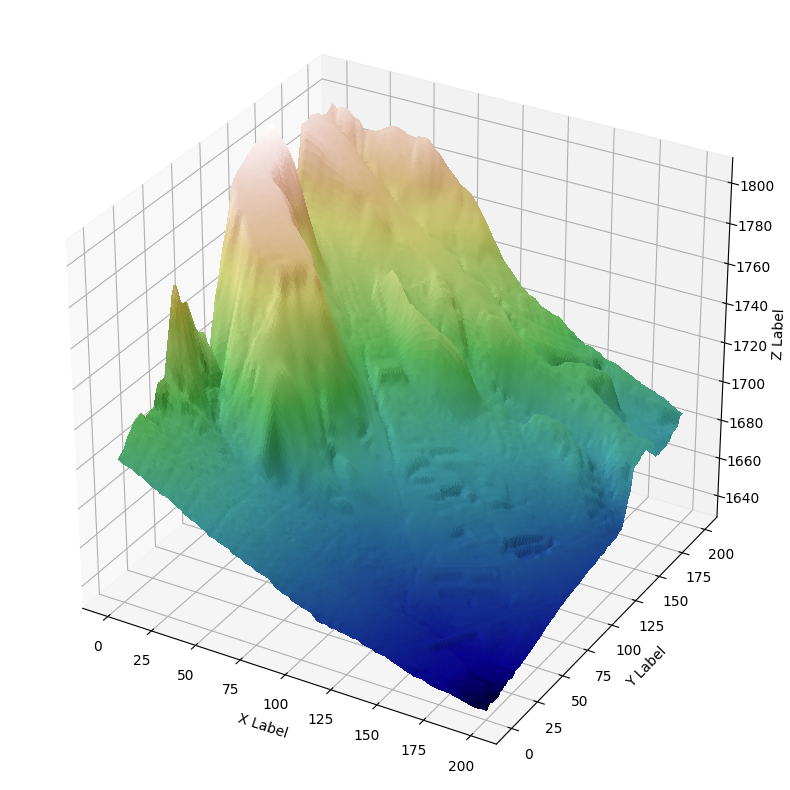

1632.3253 1808.7428


In [11]:
min_val = 9998
max_val = -9998
eval_C_proc = np.copy(elevation_C[:200,7812:8012])

gen(eval_C_proc)
draw_plt(eval_C_proc, min_val, max_val)
print(min_val, max_val)

In [50]:
np.savetxt("first.txt", eval_C_proc)

In [42]:
print(elevation_C[:200,9312:10312])
min_val, max_val, elevation_C.shape

[[1638.0398 1637.8033 1637.6035 ... 1564.4567 1563.128  1562.701 ]
 [1638.4497 1638.3105 1638.1964 ... 1565.8461 1565.383  1564.9614]
 [1638.8693 1638.8292 1638.904  ... 1569.6001 1569.3314 1569.1176]
 ...
 [1642.7836 1643.166  1643.1232 ... 1606.2416 1606.1715 1606.3059]
 [1642.6672 1643.1726 1643.2311 ... 1606.3322 1606.3408 1606.807 ]
 [1642.6084 1642.9775 1643.2664 ... 1606.4318 1606.4886 1607.0452]]


(1550.7633, 1649.3796, (10812, 10812))

## Generator

In [14]:
elevation_C.shape

(10812, 10812)

In [15]:
#making .txt arrays with size 200x200
# from data square (0, 4000) - (2000, 4000) 
def data_generator(arr, size_x, size_y, start_x, start_y, num):
    init_name = '../Data/mount_arr'
    for i in range(num):
        file_name = init_name + str(i)
        st_x = start_x + i * size_x
        st_y = start_y + i * size_y
        end_x = st_x + size_x
        end_y = st_y + size_y
        arr_to_save = np.copy(arr[st_x:end_x, st_y:end_y])
        np.savetxt(file_name, arr_to_save)

In [16]:
data_generator(elevation_C, 200, 200, 200, 200, 20)

<Figure size 8000x8000 with 0 Axes>

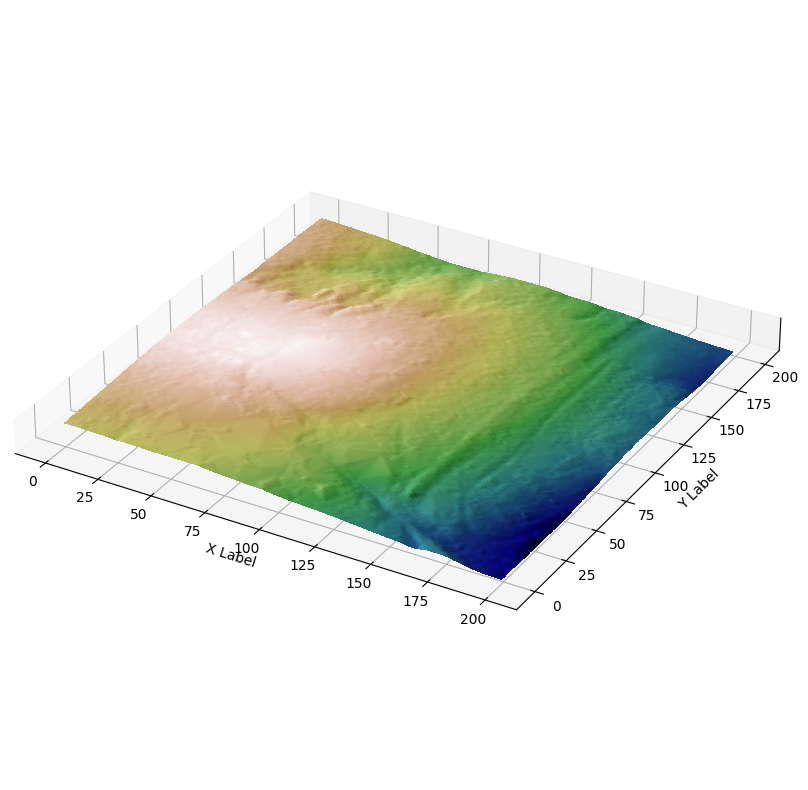

In [20]:
min_val = 9998
max_val = -9998
np_arr = np.loadtxt("../Data/data_elev_arr1")
gen(np_arr)
draw_plt(np_arr, min_val, max_val)

## colorbars

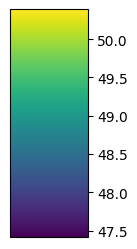

In [72]:
fig2, ax2 = plt.subplots(figsize=(6, 1))
fig2.subplots_adjust(bottom=0.5)

# cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
cb1 = mpl.colorbar.ColorbarBase(ax, norm=norm, orientation='horizontal')

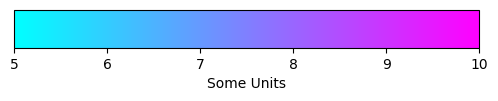

In [87]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Some Units')